Library import

In [1]:
import pandas as pd
import numpy as np
import cpi
import matplotlib.pyplot as plt

/home/yann/.local/lib/python3.8/site-packages/cpi/__init__.py:46: StaleDataWarning: CPI data is out of date. To accurately inflate to today's dollars, you must run `cpi.update()`.
  warnings.warn(StaleDataWarning())


Files loading

In [2]:
#Load movie databases
movie_df = pd.read_csv('data/MovieSummaries/movie.metadata.tsv', sep='\t', header=None)
sequel_collections_with_wiki_id = pd.read_csv('data/collections/sequels_and_original_with_wiki_id.csv')
sequels_with_wiki_id = pd.read_csv('data/movie_with_keyword_sequel_with_wiki_id.csv')

#re
movie_df.rename(columns={0: 'Wikipedia movie ID', 1: "Freebase movie ID", 2: "Movie name",  3: "Movie release date", 4: "Movie box office revenue", 5: "Movie runtime", 6: "Movie languages", 7: "Movie countries", 8: "Movie genres"}, inplace=True)

Inner join between "movie_df" and sequels with their Wikipedia ID

In [3]:
movie_df_sequel_original = movie_df.join(sequel_collections_with_wiki_id.set_index('Wikipedia movie ID'), on="Wikipedia movie ID", how='inner')
movie_df_sequel_only = movie_df.join(sequels_with_wiki_id.set_index('Wikipedia movie ID'), on="Wikipedia movie ID", how='inner')

Filtering movies by consistent release year

In [4]:
movie_df_sequel_only["release year wiki"] = movie_df_sequel_only["Movie release date"].apply(lambda x: str(x)[:4] if str.isdigit(str(x)[:4]) else np.nan)
movie_df_sequel_only["release year tmdb"] = movie_df_sequel_only["release_date"].apply(lambda x: str(x)[:4] if str.isdigit(str(x)[:4]) else np.nan)

movie_df_sequel_only.drop(movie_df_sequel_only[movie_df_sequel_only["release year wiki"] != movie_df_sequel_only["release year tmdb"]].index, inplace=True)
movie_df_sequel_only["release year"] = movie_df_sequel_only["release year wiki"].astype(float)
movie_df_sequel_only.drop("release year tmdb", axis=1, inplace=True)
movie_df_sequel_only.drop("release year wiki", axis=1, inplace=True)


Filtering sequels and original movies by consistent release year

In [5]:
movie_df_sequel_original["release year wiki"] = movie_df_sequel_original["Movie release date"].apply(lambda x: str(x)[:4] if str.isdigit(str(x)[:4]) else np.nan)
movie_df_sequel_original["release year tmdb"] = movie_df_sequel_original["release_date"].apply(lambda x: str(x)[:4] if str.isdigit(str(x)[:4]) else np.nan)

movie_df_sequel_original.drop(movie_df_sequel_original[movie_df_sequel_original["release year wiki"] != movie_df_sequel_original["release year tmdb"]].index, inplace=True)
movie_df_sequel_original["release year"] = movie_df_sequel_original["release year wiki"].astype(float)
movie_df_sequel_original.drop("release year tmdb", axis=1, inplace=True)
movie_df_sequel_original.drop("release year wiki", axis=1, inplace=True)

### 3.1 How many sequels are there compared to movies 

Plot of number of movies per 5 year (left figure) VS. Plot of number of movies with sequels per 5 year (right figure)

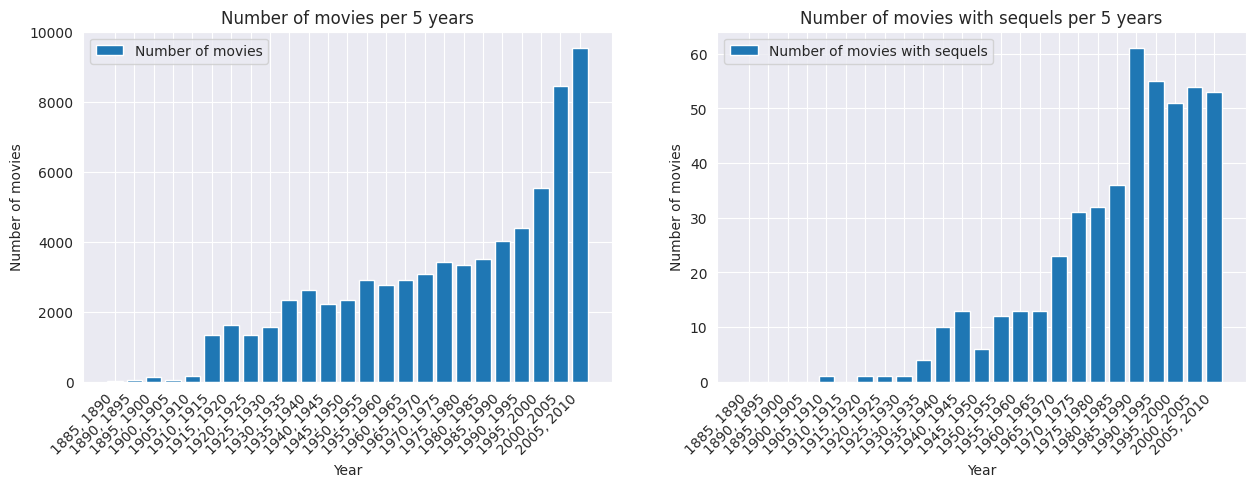

In [9]:
#extraction of the release year

movie_df["release year"] = movie_df["Movie release date"].apply(lambda x: str(x)[:4] if str.isdigit(str(x)[:4]) else np.nan)
movie_df["release year"] = movie_df["release year"].astype(float)

#keep only the movies released between 1880 and 2010 (inclusive of 1880 but excluding 2010)

    #first with movies

movie_df = movie_df[movie_df["release year"] >= 1880]
movie_df = movie_df[movie_df["release year"] < 2010]

    #then with movies with sequels

movie_df_sequel_only["release year"] = movie_df_sequel_only["release_date"].apply(lambda x: str(x)[:4] if str.isdigit(str(x)[:4]) else np.nan)
movie_df_sequel_only["release year"] = movie_df_sequel_only["release year"].astype(float)

movie_df_sequel_only = movie_df_sequel_only[movie_df_sequel_only["release year"] >= 1880]
movie_df_sequel_only = movie_df_sequel_only[movie_df_sequel_only["release year"] < 2010]

#grouping and count movies by release year

movies_per_years = movie_df.groupby(pd.cut(movie_df["release year"], np.arange(1885, 2011, 5))).count()
movies_sequel_per_year = movie_df_sequel_only.groupby(pd.cut(movie_df_sequel_only["release year"], np.arange(1885, 2011, 5))).count()

years = movies_per_years.index.astype(str)
years = [x[1:][:-1] for x in years]

#Plot figure 1 (left):  number of movies per 5 years

fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(221)
ax1.bar(years, movies_per_years["Wikipedia movie ID"], label="Number of movies")
ax1.legend()
ax1.title.set_text("Number of movies per 5 years")
ax1.set_xlabel("Year")
ax1.set_ylabel("Number of movies")
plt.xticks(rotation=45, ha='right')

#Plot figure 2 (right):  number of movies with sequels per 5 year

ax2 = fig.add_subplot(222)
ax2.bar(years, movies_sequel_per_year["Wikipedia movie ID"], label="Number of movies with sequels")
ax2.legend()
ax2.title.set_text("Number of movies with sequels per 5 years")
ax2.set_xlabel("Year")
ax2.set_ylabel("Number of movies")
plt.xticks(rotation=45, ha='right')

plt.show()

Calculation and plot of the ratio between movies with sequel and the number of movies, both per 5 years.

$$
\text{Ratio} = \frac{\text{nb of movie with sequel per 5 year}}{\text{nb of movie per 5 year}}
$$

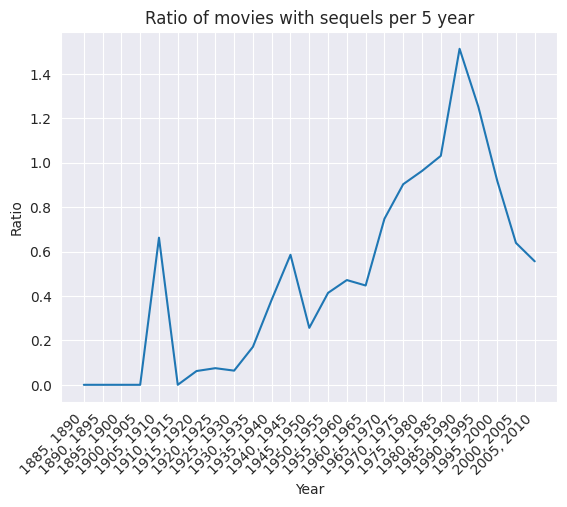

In [10]:
    #remove the years with less than 50 movies
movies_per_years_removed = movies_per_years[movies_per_years["Wikipedia movie ID"] > 50]

movie_df_ratio = movies_sequel_per_year / movies_per_years_removed * 100
movie_df_ratio = movie_df_ratio.fillna(0)

plt.plot(years, movie_df_ratio["Wikipedia movie ID"])
plt.title("Ratio of movies with sequels per 5 year")
plt.xlabel("Year")
plt.ylabel("Ratio")
plt.xticks(rotation=45, ha='right')
plt.show()

## 3.2 Box office revenue

#### 3.2.1 Box office revenue for movies with sequels compared to all movies

Creation of a function, using the Consumer Price Index (CPI), that calaculate the inflation adjustement for each movies based on their released year

In [11]:

def inflate(revenue, year):
    if np.isnan(revenue) or np.isnan(year) or year < 1900:  #no inflation adjustement for missing values or years before 1900
        return np.nan
    if len(str(year)) != 4:
        year = int(str(year)[:4])
    return cpi.inflate(revenue, year)                       #apply Consumer Price Index (cpi) inflation adjustement

# applying the function to all movies and create a new column with the adjusted revenue

movie_df["Movie box office revenue inflation adj"] = movie_df.apply(lambda x: inflate(x["Movie box office revenue"], x["release year"]), axis=1)

Box office revenues inflation adjustement for other movies with sequels dataframe

In [13]:
movie_df_sequel_only["Movie box office revenue inflation adj"] = movie_df_sequel_only.apply(lambda x: inflate(x["Movie box office revenue"], x["release year"]), axis=1)
movie_df_sequel_original["Movie box office revenue inflation adj"] = movie_df_sequel_original.apply(lambda x: inflate(x["Movie box office revenue"], x["release year"]), axis=1)

Calculation and plot of total box office revenue per year

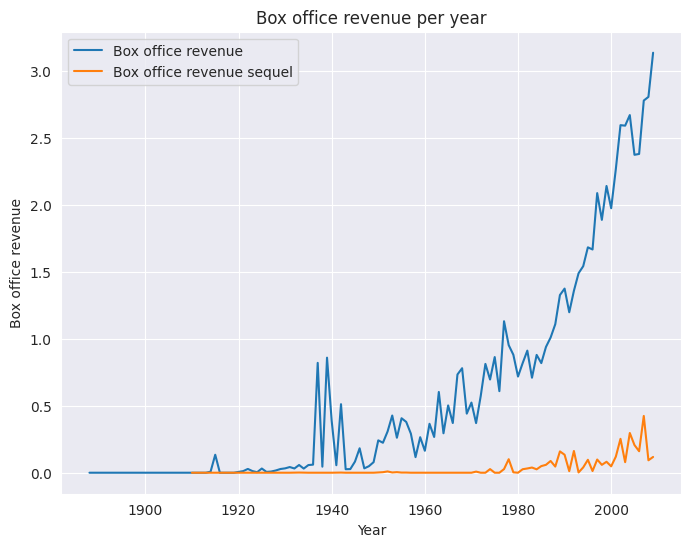

In [14]:
#sum of the box office revenue per year, first for all movies, then for movies with sequels

box_office_per_year = movie_df.groupby("release year")["Movie box office revenue inflation adj"].agg('sum')
box_office_sequel_per_year = movie_df_sequel_only.groupby("release year")["Movie box office revenue inflation adj"].agg('sum')

#replace NaN values by 0

box_office_per_year = box_office_per_year.fillna(0)
box_office_sequel_per_year = box_office_sequel_per_year.fillna(0)

"""
fig = plt.figure(figsize=(12, 10))
ax1 = fig.add_subplot()
ax1.plot(box_office_per_year.index, box_office_per_year, label="Box office revenue")
ax1.legend()
ax1.title.set_text("Box office revenue per year")
ax1.set_xlabel("Year")
ax1.set_ylabel("Box office revenue")

ax2 = fig.add_subplot()
ax2.plot(box_office_sequel_per_year.index, box_office_sequel_per_year, label="Box office revenue sequel")
ax2.legend()
ax2.title.set_text("Box office revenue sequel per year")
ax2.set_xlabel("Year")
ax2.set_ylabel("Box office revenue")
"""

# Plot figure 4: box office revenue per year

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(box_office_per_year.index, box_office_per_year, label="Box office revenue")
ax.plot(box_office_sequel_per_year.index, box_office_sequel_per_year, label="Box office revenue sequel")

plt.draw()                                                  # Draw the plot to get the current y-axis offset
y_axis_offset = ax.get_yaxis().get_offset_text().get_text() # get the scientific notation multiplier from the axis and use it in the label
ax.set_ylabel(f"Box office revenue [{y_axis_offset}$]")
ax.get_yaxis().get_offset_text().set_visible(False)         # remove the scientific notation from the axis to avoid duplication
ax.legend()
ax.set_title("Box office revenue per year")
ax.set_xlabel("Year")
ax.set_ylabel("Box office revenue")

plt.show()

Calculation and plots the percentage of box office revenue each year contributed by movies with sequels, relative to the total box office revenue for all movies that year

$$
\text{Box Office \%} = \frac{\text{Box office of movies with sequel per year}}{\text{Box office for all movies per year}} * 100
$$

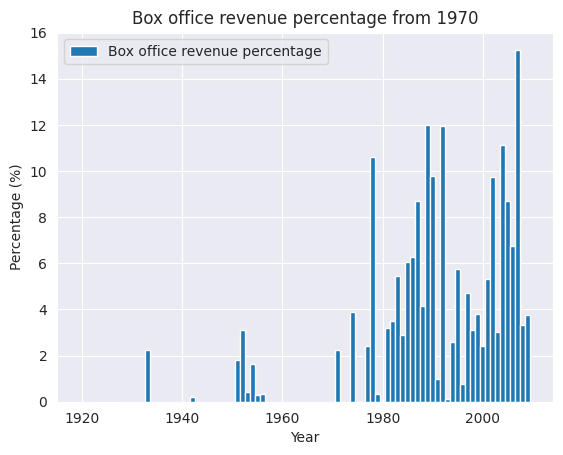

In [15]:
# calculate the percentage of box office revenue from movies with sequels

box_office_percentage = box_office_sequel_per_year / box_office_per_year * 100

# Plot figure 5: box office revenue percentage per year

box_office_percentage_plot, ax = plt.subplots()
ax.bar(box_office_percentage.index, box_office_percentage, label="Box office revenue percentage", width=1)
ax.legend(loc='upper left')
ax.title.set_text("Box office revenue percentage from 1970")
ax.set_xlabel("Year")
ax.set_ylabel("Percentage (%)")

plt.show()

Calculation and plot of the average inflation-adjusted box office revenue per year, both for all movies and for movies with sequels

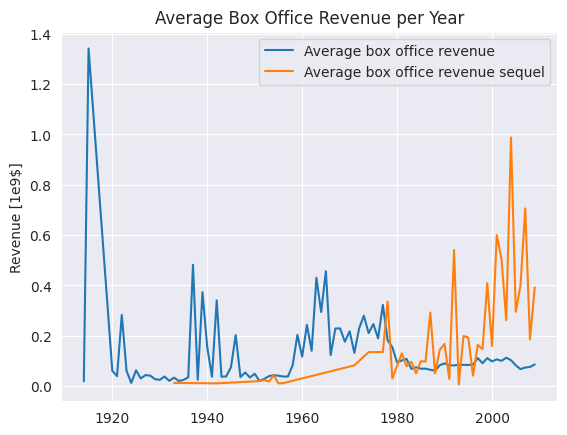

In [16]:
#calculate box office revenue per movie and fill NaN values with 0

average_box_office = movie_df.dropna(subset = ['Movie box office revenue inflation adj']).groupby("release year")["Movie box office revenue inflation adj"].agg('mean')
average_box_office = average_box_office.fillna(0)

#calculate box office revenue per movie for movies with sequels and fill NaN values with 0

average_box_office_sequel = movie_df_sequel_only.dropna(subset = ['Movie box office revenue inflation adj']).groupby("release year")["Movie box office revenue inflation adj"].agg('mean')
average_box_office_sequel = average_box_office_sequel.fillna(0)

# Plot figure 6: average box office revenue per year

average_box_office_plot, ax = plt.subplots()
ax.plot(average_box_office.index, average_box_office, label="Average box office revenue")
ax.plot(average_box_office_sequel.index, average_box_office_sequel, label="Average box office revenue sequel")

plt.draw()                                                  # Draw the plot to get the current y-axis offset
y_axis_offset = ax.get_yaxis().get_offset_text().get_text() # get the scientific notation multiplier from the axis and use it in the label
ax.set_ylabel(f"Revenue [{y_axis_offset}$]")
ax.get_yaxis().get_offset_text().set_visible(False)         # remove the scientific notation from the axis to avoid duplication
ax.legend()
ax.set_title("Average Box Office Revenue per Year")
plt.show()

#### 3.2.2 Box office revenue for movies with sequel compared to the first movie of the collection

In [17]:
#identify and calculate the box office revenue of the first movie in each collection

box_office_first_movie = movie_df_sequel_original.sort_values("release_date").groupby("collection").first()["Movie box office revenue inflation adj"]

#calculate the remaining box office revenue for each collection

box_office_remainder = movie_df_sequel_original.groupby("collection")["Movie box office revenue inflation adj"].agg('sum') - box_office_first_movie

#calculate the remaining box office revenue for each collection (excluding the first movie)

box_office_remainder_avg = box_office_remainder / (movie_df_sequel_original.groupby("collection").count()["Movie name"] - 1)

Creation of new DataFrame in order to store first movie and remain movies box office value

In [18]:
first_vs_rest = pd.DataFrame()
first_vs_rest["first"] = box_office_first_movie
first_vs_rest["rest"] = box_office_remainder
first_vs_rest["rest_avg"] = box_office_remainder_avg

first_vs_rest = first_vs_rest[first_vs_rest["rest"] > 0]                #remove collections with no revenue
first_vs_rest = first_vs_rest.sort_values("first", ascending=True)      #sort in ascending order for the first movie (lowest to the highest)

In [19]:
first_vs_rest['index'] = range(0, len(first_vs_rest))

Plot the comparison between first and remaining movie of collections

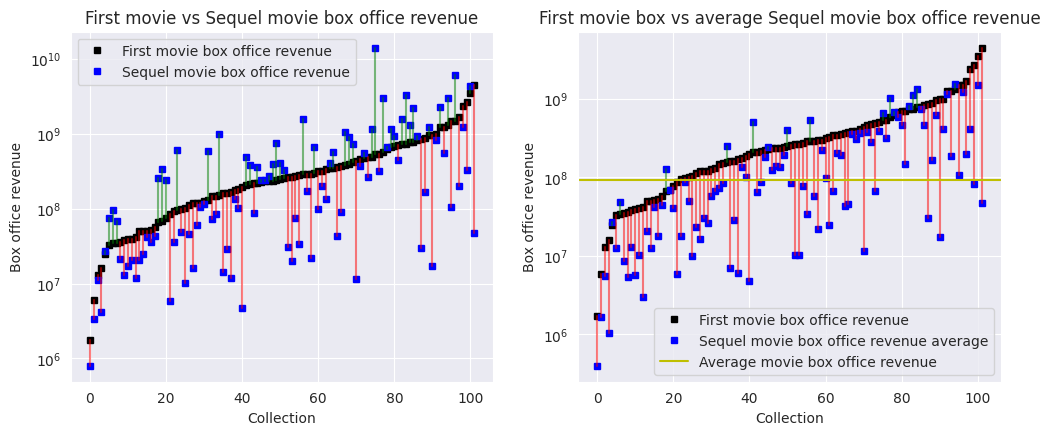

In [23]:
fig = plt.figure(figsize=(12, 10))

#calculate the average adjusted box office revenue for all movies

average_movie_revenue = movie_df.dropna(subset = ['Movie box office revenue inflation adj'])["Movie box office revenue inflation adj"].agg('mean')

#Plot figure 7: first movie vs sequel movie box office revenue

ax1 = fig.add_subplot(221)
x = first_vs_rest["index"]
y1 = first_vs_rest["first"]
y2 = first_vs_rest["rest"]
ax1.plot(x, y1, 'ks', markersize = 4, label="First movie box office revenue")
ax1.plot(x, y2, 'bs', markersize = 4, label="Sequel movie box office revenue")

ax1.plot((x[y1>y2],x[y1>y2]),(y1[y1>y2], y2[y1 > y2]),c= "red", alpha=0.5)      #the first movie has a lower revenue than the sequel
ax1.plot((x[y1<y2],x[y1<y2]),(y1[y1<y2], y2[y1 < y2]),c= "green", alpha=0.5)    #the first movie has a higher revenue than the sequel

ax1.legend()
ax1.title.set_text("First movie vs Sequel movie box office revenue")
ax1.set_xlabel("Collection")
ax1.set_ylabel("Box office revenue")
ax1.set_yscale("log")

#Plot figure 8: first movie vs average sequel movie box office revenue

ax2 = fig.add_subplot(222)
x = first_vs_rest["index"]
y1 = first_vs_rest["first"]
y2 = first_vs_rest["rest_avg"]
ax2.plot(x, y1, 'ks', markersize = 4, label="First movie box office revenue")
ax2.plot(x, y2, 'bs', markersize = 4, label="Sequel movie box office revenue average")

ax2.plot((x[y1>y2],x[y1>y2]),(y1[y1>y2], y2[y1 > y2]),c= "red", alpha=0.5)                                  #the first movie has a lower revenue than the average sequel
ax2.plot((x[y1<y2],x[y1<y2]),(y1[y1<y2], y2[y1 < y2]),c= "green", alpha=0.5)                                #the first movie has a higher revenue than the average sequel
ax2.axhline(y=average_movie_revenue, color='y', linestyle='-', label="Average movie box office revenue")    #average revenue for all movies

ax2.legend()
ax2.title.set_text("First movie box vs average Sequel movie box office revenue")
ax2.set_xlabel("Collection")
ax2.set_ylabel("Box office revenue")
ax2.set_yscale("log")

plt.show()


These plots highlight where the first movie outperforms the sequel (red lines) and vice versa (green lines). The second plot also includes a yellow horizontal line showing the average box office revenue of all movies in the dataset.

The log scale on the y-axis is used to better visualize large differences in revenue, especially when there are very high values.

## 4. Number of movies in a collection

In [31]:
#total number of movies in each collection

collection_size = movie_df_sequel_original.groupby("collection").count()["Movie name"]

#total inflation adjusted box office revenue for each collection

box_office_revenue = movie_df_sequel_original.groupby("collection")["Movie box office revenue inflation adj"].agg('sum')

sequels_extended = pd.read_csv("data/sequels/sequels_extended_1880_2010.csv") #dataframe with additional budget information
movie_df_sequel_original = pd.merge(movie_df_sequel_original, sequels_extended[["id", "budget"]], on="id", how="inner") if "budget" not in movie_df_sequel_original.columns else movie_df_sequel_original

#total budget for each collection

budget_df = movie_df_sequel_original.groupby("collection")["budget"].agg('sum')

Plot of the comparison between the Budget and the Box office revenue for collection

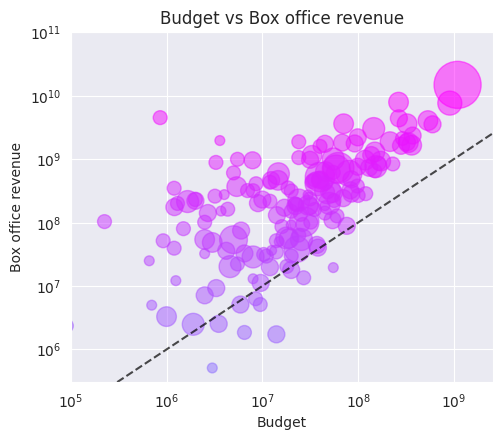

In [32]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(221)

ax.scatter(budget_df, box_office_revenue, s = collection_size * 50, alpha=0.5, c = np.log(box_office_revenue + 1), cmap="cool")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Budget")
ax.set_ylabel("Box office revenue")

ax.set_xlim(xmin = 1e5)
ax.set_ylim(ymax = 1e11)

plt.axline((0,0), xy2=(1e11, 1e11), linestyle='--',color='black', alpha=0.7, label = "Profit Line")
ax.title.set_text("Budget vs Box office revenue")
plt.show()

Other line of enquiry:

Highest grossing series

By genre

Find studios that do a lot of sequels

Is there a correlation between the box office revenue of the first movie and the sequels

Add more box office revenue data and get movie budget data

#### Time between sequels

In [33]:
first_movie = movie_df_sequel_original.sort_values("release_date").groupby("collection").first()
sequel_movies = movie_df_sequel_original.sort_values("release_date").groupby("collection").tail(-1)

In [36]:
collection_release_date = pd.DataFrame()
collection_release_date["collection"] = first_movie.index
collection_release_date["movie date"] = first_movie["release_date"].values
collection_release_date["movie title"] = first_movie["Movie name"].values
collection_release_date["Movie box office revenue inflation adj"] = first_movie["Movie box office revenue inflation adj"].values
collection_release_date = collection_release_date.sort_values("Movie box office revenue inflation adj", ascending=False).head(50)

sequel_temp = pd.DataFrame()
sequel_movies_top = sequel_movies[sequel_movies["collection"].isin(collection_release_date["collection"].values)]
sequel_temp["collection"] = sequel_movies_top["collection"].values
sequel_temp["movie date"] = sequel_movies_top["release_date"].values
sequel_temp["movie title"] = sequel_movies_top["Movie name"].values
sequel_temp["Movie box office revenue inflation adj"] = sequel_movies_top["Movie box office revenue inflation adj"].values

collection_release_date = pd.concat([collection_release_date, sequel_temp])
collection_release_date["movie date"] = pd.to_datetime(collection_release_date["movie date"])
collection_release_date["collection"] = collection_release_date["collection"].apply(lambda x: x.replace(" Collection", ""))

time_from_last = []
prequel_name = []
prequel_date = []
collection_release_date = collection_release_date.sort_values(["collection", "movie date"])
previous= 0
collection_previous = ""
movie_previous = ""
for movie in collection_release_date.iterrows():
    collection = movie[1]["collection"]
    date = movie[1]["movie date"]
    if(collection != collection_previous):
        prequel_name.append(None)
        time_from_last.append(0)
        prequel_date.append(None)
    else :
        time_from_last.append((date - previous).days)
        prequel_name.append(movie_previous)
        prequel_date.append(previous)
    previous = date
    collection_previous = collection 
    movie_previous = movie[1]["movie title"]
    
collection_release_date["time from last"] = time_from_last
collection_release_date["prequel name"] = prequel_name
collection_release_date["prequel date"] = prequel_date
collection_release_date = collection_release_date[collection_release_date.groupby("collection").collection.transform(len) > 1]

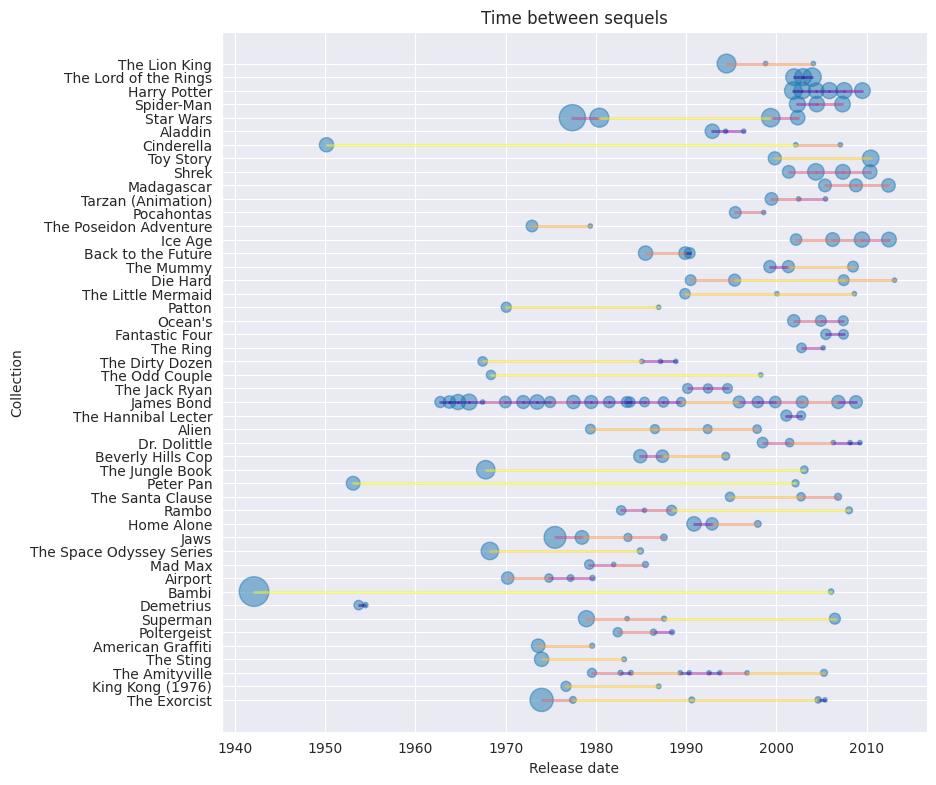

In [37]:
from matplotlib import colormaps
from matplotlib import cm

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(221)

collection_release_date = collection_release_date.sort_values("Movie box office revenue inflation adj", ascending=True)
x = collection_release_date["movie date"]
y = collection_release_date["collection"]


ax.scatter(x, y, s = 10 + collection_release_date["Movie box office revenue inflation adj"].fillna(0)/10000000, alpha=0.5)

x_line, y_line = np.array([]), np.array([])

max_time = collection_release_date["time from last"].max()

time = collection_release_date["time from last"].values
time =  time[time != 0]

color = cm.plasma(np.linspace(0, 1, num=time.shape[0]))

collection_release_date = collection_release_date.sort_values("time from last")
j=0
for i, movie in collection_release_date.iterrows():
    prev_year = movie["prequel date"]
    curr_year = movie["movie date"]
    collection = movie["collection"]
    prev_movie = movie["prequel name"]
    if prev_movie is not None:
        x_line = np.append(x_line, [prev_year, curr_year])
        y_line = np.append(y_line, [collection, collection])
        ax.plot([prev_year, curr_year], [collection, collection], alpha=0.5, c = color[j], linewidth=2)
        j += 1
    
ax.set_xlabel("Release date")
ax.set_ylabel("Collection")
ax.title.set_text("Time between sequels")
plt.rc('ytick', labelsize=8)
plt.show()

#### Time Histogram

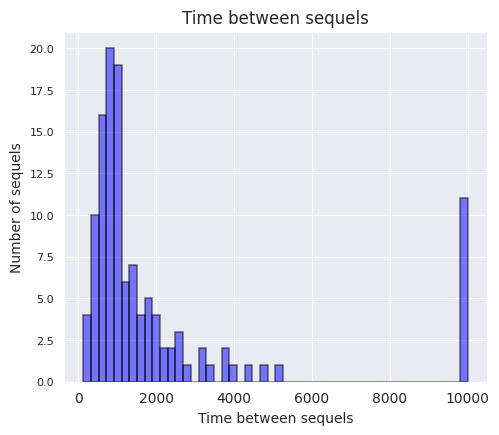

In [38]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(221)

time = collection_release_date["time from last"].apply(lambda x: x if x < 6000 else 10000).values
time =  time[time != 0]



ax.hist(time, bins=50, alpha=0.5, color='b', edgecolor='black', linewidth=1.2)
ax.set_xlabel("Time between sequels")
ax.set_ylabel("Number of sequels")
ax.title.set_text("Time between sequels")
plt.show()